In [ ]:
%%capture
!pip install super-gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

Importing all the required libraries**

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

[2024-04-26 02:12:51] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-04-26 02:13:03] INFO - utils.py - NumExpr defaulting to 2 threads.


In [ ]:
from IPython.display import clear_output


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback



In [ ]:
from super_gradients.training import models


Setting the checkpoint directory and experiment name | Instantiated the trainer

In [ ]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='sign_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

Exporting the Dataset from Roboflow into the Google Colab Notebook

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6dKb7BLrqME4OgSn5kUI")
project = rf.workspace("asl-recognization").project("asl-recognization-7spux")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.


Extracting Dataset Version Zip to ASL-Recognization-1 in yolov8::  69%|██████▉   | 1603/2316 [00:00<00:00, 2933.99it/s]

dataset parameters in a dictionary

Parameters specifically defined:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [ ]:
dataset_params = {
    'data_dir':'/content/ASL-Recognization-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['A', 'B', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L','M','N','O', 'P', 'Q', 'R', 'S', 'T', 'U',  'V', 'W', 'X', 'Y']
}

Pass the values for `dataset_params` into the `dataset_params` argument

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Inspect the Dataset Defined Earlier

In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

Indexing dataset annotations: 100%|██████████| 72/72 [00:00<00:00, 5071.97it/s]


Ploting a batch of training data with their augmentations applied to see what they look like

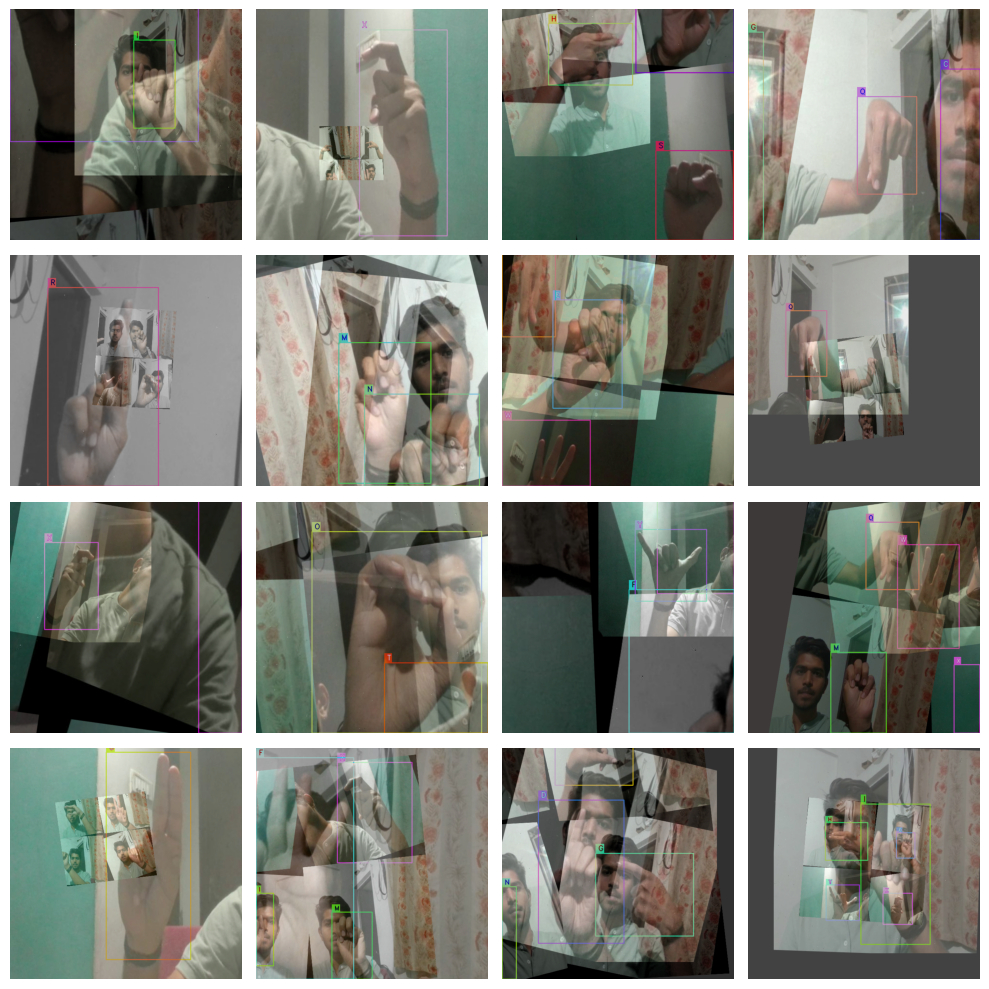

In [ ]:
train_data.dataset.plot()

Instantiating the model

1.   List item
2.   List item



In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-04-26 02:13:28] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-04-26 02:13:28] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:02<00:00, 32.7MB/s]
[2024-04-26 02:13:31] INFO - checkpo

📊 Define metrics and training parameters


defining the training parameters for your training run.

Details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


Arguments Defined:

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

Optimizer used will be Adam


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "LinearEpochLRWarmup",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        # reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

Download the Demo Videos

In [ ]:
!gdown "https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t"

Training the model

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

Downloading...
From: https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t
To: /content/demonew1.mp4
100% 1.26M/1.26M [00:00<00:00, 57.7MB/s]


[2024-04-26 02:13:44] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240426_021344_609268`
[2024-04-26 02:13:44] INFO - sg_trainer.py - Checkpoints directory: checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268
[2024-04-26 02:13:44] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/console_Apr26_02_13_44.txt


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[2024-04-26 02:13:54] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         63         (len(train_loader))
    - Gradient updates per epoch:   63         (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.03M parameters, 19.03M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.03M parameters). LR: 0.0005 (19.03M par

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 7.2157
│   ├── Ppyoloeloss/loss_iou = 0.8569
│   ├── Ppyoloeloss/loss_dfl = 1.0027
│   └── Ppyoloeloss/loss = 9.0753
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.3373
    ├── Ppyoloeloss/loss_iou = 0.6267
    ├── Ppyoloeloss/loss_dfl = 0.8735
    ├── Ppyoloeloss/loss = 3.8374
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0007
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.06



Validating epoch 1: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
[2024-04-26 02:16:37] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:16:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.13607731461524963


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9371
│   │   ├── Epoch N-1      = 7.2157 (↘ -5.2786)
│   │   └── Best until now = 7.2157 (↘ -5.2786)
│   ├── Ppyoloeloss/loss_iou = 0.6933
│   │   ├── Epoch N-1      = 0.8569 (↘ -0.1636)
│   │   └── Best until now = 0.8569 (↘ -0.1636)
│   ├── Ppyoloeloss/loss_dfl = 0.8345
│   │   ├── Epoch N-1      = 1.0027 (↘ -0.1682)
│   │   └── Best until now = 1.0027 (↘ -0.1682)
│   └── Ppyoloeloss/loss = 3.465
│       ├── Epoch N-1      = 9.0753 (↘ -5.6103)
│       └── Best until now = 9.0753 (↘ -5.6103)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.0366
    │   ├── Epoch N-1      = 2.3373 (↗ 0.6994)
    │   └── Best until now = 2.3373 (↗ 0.6994)
    ├── Ppyoloeloss/loss_iou = 0.7096
    │   ├── Epoch N-1      = 0.6267 (↗ 0.083)
    │   └── Best until now = 0.6267 (↗ 0.083)
    ├── Ppyoloeloss/loss_dfl = 0.8681
    │   ├── Epoch N-1      = 0.8735 (↘ -0.0054)
    │   └── Best until now = 0.8735 (↘ -0.0054)
    ├── Ppyoloeloss/loss = 4.

Validating epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]
[2024-04-26 02:17:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:17:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.35449105501174927


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.7042
│   │   ├── Epoch N-1      = 1.9371 (↘ -0.2329)
│   │   └── Best until now = 1.9371 (↘ -0.2329)
│   ├── Ppyoloeloss/loss_iou = 0.5919
│   │   ├── Epoch N-1      = 0.6933 (↘ -0.1014)
│   │   └── Best until now = 0.6933 (↘ -0.1014)
│   ├── Ppyoloeloss/loss_dfl = 0.7457
│   │   ├── Epoch N-1      = 0.8345 (↘ -0.0888)
│   │   └── Best until now = 0.8345 (↘ -0.0888)
│   └── Ppyoloeloss/loss = 3.0418
│       ├── Epoch N-1      = 3.465  (↘ -0.4232)
│       └── Best until now = 3.465  (↘ -0.4232)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.1701
    │   ├── Epoch N-1      = 3.0366 (↘ -0.8665)
    │   └── Best until now = 2.3373 (↘ -0.1672)
    ├── Ppyoloeloss/loss_iou = 0.4803
    │   ├── Epoch N-1      = 0.7096 (↘ -0.2293)
    │   └── Best until now = 0.6267 (↘ -0.1463)
    ├── Ppyoloeloss/loss_dfl = 0.6711
    │   ├── Epoch N-1      = 0.8681 (↘ -0.197)
    │   └── Best until now = 0.8681 (↘ -0.197)
    ├── Ppyoloeloss/loss

Validating epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]
[2024-04-26 02:19:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:19:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.592978298664093


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5684
│   │   ├── Epoch N-1      = 1.7042 (↘ -0.1357)
│   │   └── Best until now = 1.7042 (↘ -0.1357)
│   ├── Ppyoloeloss/loss_iou = 0.5549
│   │   ├── Epoch N-1      = 0.5919 (↘ -0.037)
│   │   └── Best until now = 0.5919 (↘ -0.037)
│   ├── Ppyoloeloss/loss_dfl = 0.7293
│   │   ├── Epoch N-1      = 0.7457 (↘ -0.0164)
│   │   └── Best until now = 0.7457 (↘ -0.0164)
│   └── Ppyoloeloss/loss = 2.8526
│       ├── Epoch N-1      = 3.0418 (↘ -0.1892)
│       └── Best until now = 3.0418 (↘ -0.1892)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.367
    │   ├── Epoch N-1      = 2.1701 (↗ 0.197)
    │   └── Best until now = 2.1701 (↗ 0.197)
    ├── Ppyoloeloss/loss_iou = 0.4499
    │   ├── Epoch N-1      = 0.4803 (↘ -0.0305)
    │   └── Best until now = 0.4803 (↘ -0.0305)
    ├── Ppyoloeloss/loss_dfl = 0.7088
    │   ├── Epoch N-1      = 0.6711 (↗ 0.0378)
    │   └── Best until now = 0.6711 (↗ 0.0378)
    ├── Ppyoloeloss/loss = 3.52

Validating epoch 4: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]
[2024-04-26 02:20:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:20:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6967230439186096


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4661
│   │   ├── Epoch N-1      = 1.5684 (↘ -0.1024)
│   │   └── Best until now = 1.5684 (↘ -0.1024)
│   ├── Ppyoloeloss/loss_iou = 0.5191
│   │   ├── Epoch N-1      = 0.5549 (↘ -0.0358)
│   │   └── Best until now = 0.5549 (↘ -0.0358)
│   ├── Ppyoloeloss/loss_dfl = 0.7066
│   │   ├── Epoch N-1      = 0.7293 (↘ -0.0226)
│   │   └── Best until now = 0.7293 (↘ -0.0226)
│   └── Ppyoloeloss/loss = 2.6918
│       ├── Epoch N-1      = 2.8526 (↘ -0.1608)
│       └── Best until now = 2.8526 (↘ -0.1608)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3324
    │   ├── Epoch N-1      = 2.367  (↘ -1.0346)
    │   └── Best until now = 2.1701 (↘ -0.8377)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4499 (↘ -0.0343)
    │   └── Best until now = 0.4499 (↘ -0.0343)
    ├── Ppyoloeloss/loss_dfl = 0.6475
    │   ├── Epoch N-1      = 0.7088 (↘ -0.0613)
    │   └── Best until now = 0.6711 (↘ -0.0235)
    ├── Ppyoloeloss/lo

Validating epoch 5: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3629
│   │   ├── Epoch N-1      = 1.4661 (↘ -0.1032)
│   │   └── Best until now = 1.4661 (↘ -0.1032)
│   ├── Ppyoloeloss/loss_iou = 0.5031
│   │   ├── Epoch N-1      = 0.5191 (↘ -0.016)
│   │   └── Best until now = 0.5191 (↘ -0.016)
│   ├── Ppyoloeloss/loss_dfl = 0.6797
│   │   ├── Epoch N-1      = 0.7066 (↘ -0.0269)
│   │   └── Best until now = 0.7066 (↘ -0.0269)
│   └── Ppyoloeloss/loss = 2.5458
│       ├── Epoch N-1      = 2.6918 (↘ -0.1461)
│       └── Best until now = 2.6918 (↘ -0.1461)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2666
    │   ├── Epoch N-1      = 1.3324 (↘ -0.0659)
    │   └── Best until now = 1.3324 (↘ -0.0659)
    ├── Ppyoloeloss/loss_iou = 0.4286
    │   ├── Epoch N-1      = 0.4156 (↗ 0.013)
    │   └── Best until now = 0.4156 (↗ 0.013)
    ├── Ppyoloeloss/loss_dfl = 0.6442
    │   ├── Epoch N-1      = 0.6475 (↘ -0.0034)
    │   └── Best until now = 0.6475 (↘ -0.0034)
    ├── Ppyoloeloss/loss = 2

Validating epoch 6: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]
[2024-04-26 02:22:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:22:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8223255276679993


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.308
│   │   ├── Epoch N-1      = 1.3629 (↘ -0.0549)
│   │   └── Best until now = 1.3629 (↘ -0.0549)
│   ├── Ppyoloeloss/loss_iou = 0.4873
│   │   ├── Epoch N-1      = 0.5031 (↘ -0.0158)
│   │   └── Best until now = 0.5031 (↘ -0.0158)
│   ├── Ppyoloeloss/loss_dfl = 0.6645
│   │   ├── Epoch N-1      = 0.6797 (↘ -0.0152)
│   │   └── Best until now = 0.6797 (↘ -0.0152)
│   └── Ppyoloeloss/loss = 2.4598
│       ├── Epoch N-1      = 2.5458 (↘ -0.0859)
│       └── Best until now = 2.5458 (↘ -0.0859)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.151
    │   ├── Epoch N-1      = 1.2666 (↘ -0.1155)
    │   └── Best until now = 1.2666 (↘ -0.1155)
    ├── Ppyoloeloss/loss_iou = 0.4251
    │   ├── Epoch N-1      = 0.4286 (↘ -0.0034)
    │   └── Best until now = 0.4156 (↗ 0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.6698
    │   ├── Epoch N-1      = 0.6442 (↗ 0.0256)
    │   └── Best until now = 0.6442 (↗ 0.0256)
    ├── Ppyoloeloss/loss = 

Validating epoch 7: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]
[2024-04-26 02:24:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:24:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8918125033378601


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2584
│   │   ├── Epoch N-1      = 1.308  (↘ -0.0496)
│   │   └── Best until now = 1.308  (↘ -0.0496)
│   ├── Ppyoloeloss/loss_iou = 0.4808
│   │   ├── Epoch N-1      = 0.4873 (↘ -0.0066)
│   │   └── Best until now = 0.4873 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.6572
│   │   ├── Epoch N-1      = 0.6645 (↘ -0.0073)
│   │   └── Best until now = 0.6645 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 2.3963
│       ├── Epoch N-1      = 2.4598 (↘ -0.0635)
│       └── Best until now = 2.4598 (↘ -0.0635)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1895
    │   ├── Epoch N-1      = 1.151  (↗ 0.0385)
    │   └── Best until now = 1.151  (↗ 0.0385)
    ├── Ppyoloeloss/loss_iou = 0.3995
    │   ├── Epoch N-1      = 0.4251 (↘ -0.0256)
    │   └── Best until now = 0.4156 (↘ -0.0161)
    ├── Ppyoloeloss/loss_dfl = 0.6338
    │   ├── Epoch N-1      = 0.6698 (↘ -0.0359)
    │   └── Best until now = 0.6442 (↘ -0.0103)
    ├── Ppyoloeloss/loss

Validating epoch 8: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
[2024-04-26 02:25:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:25:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9570362567901611


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2005
│   │   ├── Epoch N-1      = 1.2584 (↘ -0.0578)
│   │   └── Best until now = 1.2584 (↘ -0.0578)
│   ├── Ppyoloeloss/loss_iou = 0.4766
│   │   ├── Epoch N-1      = 0.4808 (↘ -0.0042)
│   │   └── Best until now = 0.4808 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6554
│   │   ├── Epoch N-1      = 0.6572 (↘ -0.0019)
│   │   └── Best until now = 0.6572 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 2.3325
│       ├── Epoch N-1      = 2.3963 (↘ -0.0639)
│       └── Best until now = 2.3963 (↘ -0.0639)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1167
    │   ├── Epoch N-1      = 1.1895 (↘ -0.0728)
    │   └── Best until now = 1.151  (↘ -0.0343)
    ├── Ppyoloeloss/loss_iou = 0.4016
    │   ├── Epoch N-1      = 0.3995 (↗ 0.0021)
    │   └── Best until now = 0.3995 (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.6398
    │   ├── Epoch N-1      = 0.6338 (↗ 0.006)
    │   └── Best until now = 0.6338 (↗ 0.006)
    ├── Ppyoloeloss/loss = 2

Validating epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1629
│   │   ├── Epoch N-1      = 1.2005 (↘ -0.0376)
│   │   └── Best until now = 1.2005 (↘ -0.0376)
│   ├── Ppyoloeloss/loss_iou = 0.4681
│   │   ├── Epoch N-1      = 0.4766 (↘ -0.0085)
│   │   └── Best until now = 0.4766 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.6408
│   │   ├── Epoch N-1      = 0.6554 (↘ -0.0145)
│   │   └── Best until now = 0.6554 (↘ -0.0145)
│   └── Ppyoloeloss/loss = 2.2719
│       ├── Epoch N-1      = 2.3325 (↘ -0.0606)
│       └── Best until now = 2.3325 (↘ -0.0606)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0059
    │   ├── Epoch N-1      = 1.1167 (↘ -0.1108)
    │   └── Best until now = 1.1167 (↘ -0.1108)
    ├── Ppyoloeloss/loss_iou = 0.4468
    │   ├── Epoch N-1      = 0.4016 (↗ 0.0452)
    │   └── Best until now = 0.3995 (↗ 0.0473)
    ├── Ppyoloeloss/loss_dfl = 0.6808
    │   ├── Epoch N-1      = 0.6398 (↗ 0.041)
    │   └── Best until now = 0.6338 (↗ 0.047)
    ├── Ppyoloeloss/loss = 2

Validating epoch 10: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1205
│   │   ├── Epoch N-1      = 1.1629 (↘ -0.0424)
│   │   └── Best until now = 1.1629 (↘ -0.0424)
│   ├── Ppyoloeloss/loss_iou = 0.4619
│   │   ├── Epoch N-1      = 0.4681 (↘ -0.0062)
│   │   └── Best until now = 0.4681 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.636
│   │   ├── Epoch N-1      = 0.6408 (↘ -0.0048)
│   │   └── Best until now = 0.6408 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 2.2185
│       ├── Epoch N-1      = 2.2719 (↘ -0.0534)
│       └── Best until now = 2.2719 (↘ -0.0534)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9571
    │   ├── Epoch N-1      = 1.0059 (↘ -0.0488)
    │   └── Best until now = 1.0059 (↘ -0.0488)
    ├── Ppyoloeloss/loss_iou = 0.3991
    │   ├── Epoch N-1      = 0.4468 (↘ -0.0477)
    │   └── Best until now = 0.3995 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.628
    │   ├── Epoch N-1      = 0.6808 (↘ -0.0528)
    │   └── Best until now = 0.6338 (↘ -0.0058)
    ├── Ppyoloeloss/los

Validating epoch 11: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0897
│   │   ├── Epoch N-1      = 1.1205 (↘ -0.0308)
│   │   └── Best until now = 1.1205 (↘ -0.0308)
│   ├── Ppyoloeloss/loss_iou = 0.4552
│   │   ├── Epoch N-1      = 0.4619 (↘ -0.0067)
│   │   └── Best until now = 0.4619 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.628
│   │   ├── Epoch N-1      = 0.636  (↘ -0.008)
│   │   └── Best until now = 0.636  (↘ -0.008)
│   └── Ppyoloeloss/loss = 2.173
│       ├── Epoch N-1      = 2.2185 (↘ -0.0455)
│       └── Best until now = 2.2185 (↘ -0.0455)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.946
    │   ├── Epoch N-1      = 0.9571 (↘ -0.0112)
    │   └── Best until now = 0.9571 (↘ -0.0112)
    ├── Ppyoloeloss/loss_iou = 0.4267
    │   ├── Epoch N-1      = 0.3991 (↗ 0.0276)
    │   └── Best until now = 0.3991 (↗ 0.0276)
    ├── Ppyoloeloss/loss_dfl = 0.6392
    │   ├── Epoch N-1      = 0.628  (↗ 0.0111)
    │   └── Best until now = 0.628  (↗ 0.0111)
    ├── Ppyoloeloss/loss = 2.0

Validating epoch 12: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0947
│   │   ├── Epoch N-1      = 1.0897 (↗ 0.005)
│   │   └── Best until now = 1.0897 (↗ 0.005)
│   ├── Ppyoloeloss/loss_iou = 0.4552
│   │   ├── Epoch N-1      = 0.4552 (↘ -0.0)
│   │   └── Best until now = 0.4552 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.6331
│   │   ├── Epoch N-1      = 0.628  (↗ 0.0051)
│   │   └── Best until now = 0.628  (↗ 0.0051)
│   └── Ppyoloeloss/loss = 2.183
│       ├── Epoch N-1      = 2.173  (↗ 0.0101)
│       └── Best until now = 2.173  (↗ 0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8611
    │   ├── Epoch N-1      = 0.946  (↘ -0.0849)
    │   └── Best until now = 0.946  (↘ -0.0849)
    ├── Ppyoloeloss/loss_iou = 0.4119
    │   ├── Epoch N-1      = 0.4267 (↘ -0.0149)
    │   └── Best until now = 0.3991 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.6426
    │   ├── Epoch N-1      = 0.6392 (↗ 0.0034)
    │   └── Best until now = 0.628  (↗ 0.0146)
    ├── Ppyoloeloss/loss = 1.9155
    │

Validating epoch 13: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0565
│   │   ├── Epoch N-1      = 1.0947 (↘ -0.0382)
│   │   └── Best until now = 1.0897 (↘ -0.0332)
│   ├── Ppyoloeloss/loss_iou = 0.45
│   │   ├── Epoch N-1      = 0.4552 (↘ -0.0052)
│   │   └── Best until now = 0.4552 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.6229
│   │   ├── Epoch N-1      = 0.6331 (↘ -0.0102)
│   │   └── Best until now = 0.628  (↘ -0.0051)
│   └── Ppyoloeloss/loss = 2.1294
│       ├── Epoch N-1      = 2.183  (↘ -0.0537)
│       └── Best until now = 2.173  (↘ -0.0436)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9246
    │   ├── Epoch N-1      = 0.8611 (↗ 0.0635)
    │   └── Best until now = 0.8611 (↗ 0.0635)
    ├── Ppyoloeloss/loss_iou = 0.4402
    │   ├── Epoch N-1      = 0.4119 (↗ 0.0283)
    │   └── Best until now = 0.3991 (↗ 0.0411)
    ├── Ppyoloeloss/loss_dfl = 0.6694
    │   ├── Epoch N-1      = 0.6426 (↗ 0.0268)
    │   └── Best until now = 0.628  (↗ 0.0413)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 14: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]
[2024-04-26 02:33:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/sign_yolonas_run2/RUN_20240426_021344_609268/ckpt_best.pth
[2024-04-26 02:33:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 1.0


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0143
│   │   ├── Epoch N-1      = 1.0565 (↘ -0.0421)
│   │   └── Best until now = 1.0565 (↘ -0.0421)
│   ├── Ppyoloeloss/loss_iou = 0.4426
│   │   ├── Epoch N-1      = 0.45   (↘ -0.0074)
│   │   └── Best until now = 0.45   (↘ -0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.6173
│   │   ├── Epoch N-1      = 0.6229 (↘ -0.0056)
│   │   └── Best until now = 0.6229 (↘ -0.0056)
│   └── Ppyoloeloss/loss = 2.0743
│       ├── Epoch N-1      = 2.1294 (↘ -0.0551)
│       └── Best until now = 2.1294 (↘ -0.0551)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8187
    │   ├── Epoch N-1      = 0.9246 (↘ -0.1059)
    │   └── Best until now = 0.8611 (↘ -0.0423)
    ├── Ppyoloeloss/loss_iou = 0.3992
    │   ├── Epoch N-1      = 0.4402 (↘ -0.041)
    │   └── Best until now = 0.3991 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.6221
    │   ├── Epoch N-1      = 0.6694 (↘ -0.0472)
    │   └── Best until now = 0.628  (↘ -0.0059)
    ├── Ppyoloeloss/loss

Validating epoch 15: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0036
│   │   ├── Epoch N-1      = 1.0143 (↘ -0.0108)
│   │   └── Best until now = 1.0143 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.4393
│   │   ├── Epoch N-1      = 0.4426 (↘ -0.0033)
│   │   └── Best until now = 0.4426 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.6164
│   │   ├── Epoch N-1      = 0.6173 (↘ -0.0009)
│   │   └── Best until now = 0.6173 (↘ -0.0009)
│   └── Ppyoloeloss/loss = 2.0593
│       ├── Epoch N-1      = 2.0743 (↘ -0.015)
│       └── Best until now = 2.0743 (↘ -0.015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7807
    │   ├── Epoch N-1      = 0.8187 (↘ -0.038)
    │   └── Best until now = 0.8187 (↘ -0.038)
    ├── Ppyoloeloss/loss_iou = 0.368
    │   ├── Epoch N-1      = 0.3992 (↘ -0.0312)
    │   └── Best until now = 0.3991 (↘ -0.0311)
    ├── Ppyoloeloss/loss_dfl = 0.583
    │   ├── Epoch N-1      = 0.6221 (↘ -0.0391)
    │   └── Best until now = 0.6221 (↘ -0.0391)
    ├── Ppyoloeloss/loss = 

Validating epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9897
│   │   ├── Epoch N-1      = 1.0036 (↘ -0.0139)
│   │   └── Best until now = 1.0036 (↘ -0.0139)
│   ├── Ppyoloeloss/loss_iou = 0.4368
│   │   ├── Epoch N-1      = 0.4393 (↘ -0.0025)
│   │   └── Best until now = 0.4393 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.6152
│   │   ├── Epoch N-1      = 0.6164 (↘ -0.0012)
│   │   └── Best until now = 0.6164 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 2.0417
│       ├── Epoch N-1      = 2.0593 (↘ -0.0175)
│       └── Best until now = 2.0593 (↘ -0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8063
    │   ├── Epoch N-1      = 0.7807 (↗ 0.0255)
    │   └── Best until now = 0.7807 (↗ 0.0255)
    ├── Ppyoloeloss/loss_iou = 0.4127
    │   ├── Epoch N-1      = 0.368  (↗ 0.0447)
    │   └── Best until now = 0.368  (↗ 0.0447)
    ├── Ppyoloeloss/loss_dfl = 0.6438
    │   ├── Epoch N-1      = 0.583  (↗ 0.0607)
    │   └── Best until now = 0.583  (↗ 0.0607)
    ├── Ppyoloeloss/loss = 

Validating epoch 17: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9856
│   │   ├── Epoch N-1      = 0.9897 (↘ -0.0041)
│   │   └── Best until now = 0.9897 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.4316
│   │   ├── Epoch N-1      = 0.4368 (↘ -0.0052)
│   │   └── Best until now = 0.4368 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.6134
│   │   ├── Epoch N-1      = 0.6152 (↘ -0.0018)
│   │   └── Best until now = 0.6152 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 2.0306
│       ├── Epoch N-1      = 2.0417 (↘ -0.0111)
│       └── Best until now = 2.0417 (↘ -0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7769
    │   ├── Epoch N-1      = 0.8063 (↘ -0.0294)
    │   └── Best until now = 0.7807 (↘ -0.0039)
    ├── Ppyoloeloss/loss_iou = 0.4103
    │   ├── Epoch N-1      = 0.4127 (↘ -0.0024)
    │   └── Best until now = 0.368  (↗ 0.0423)
    ├── Ppyoloeloss/loss_dfl = 0.6286
    │   ├── Epoch N-1      = 0.6438 (↘ -0.0151)
    │   └── Best until now = 0.583  (↗ 0.0456)
    ├── Ppyoloeloss/los

Validating epoch 18: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9546
│   │   ├── Epoch N-1      = 0.9856 (↘ -0.031)
│   │   └── Best until now = 0.9856 (↘ -0.031)
│   ├── Ppyoloeloss/loss_iou = 0.4231
│   │   ├── Epoch N-1      = 0.4316 (↘ -0.0085)
│   │   └── Best until now = 0.4316 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.6061
│   │   ├── Epoch N-1      = 0.6134 (↘ -0.0073)
│   │   └── Best until now = 0.6134 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 1.9838
│       ├── Epoch N-1      = 2.0306 (↘ -0.0469)
│       └── Best until now = 2.0306 (↘ -0.0469)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7402
    │   ├── Epoch N-1      = 0.7769 (↘ -0.0367)
    │   └── Best until now = 0.7769 (↘ -0.0367)
    ├── Ppyoloeloss/loss_iou = 0.3943
    │   ├── Epoch N-1      = 0.4103 (↘ -0.016)
    │   └── Best until now = 0.368  (↗ 0.0263)
    ├── Ppyoloeloss/loss_dfl = 0.6174
    │   ├── Epoch N-1      = 0.6286 (↘ -0.0112)
    │   └── Best until now = 0.583  (↗ 0.0344)
    ├── Ppyoloeloss/loss =

Validating epoch 19: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9292
│   │   ├── Epoch N-1      = 0.9546 (↘ -0.0254)
│   │   └── Best until now = 0.9546 (↘ -0.0254)
│   ├── Ppyoloeloss/loss_iou = 0.4246
│   │   ├── Epoch N-1      = 0.4231 (↗ 0.0015)
│   │   └── Best until now = 0.4231 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.598
│   │   ├── Epoch N-1      = 0.6061 (↘ -0.0081)
│   │   └── Best until now = 0.6061 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 1.9519
│       ├── Epoch N-1      = 1.9838 (↘ -0.0319)
│       └── Best until now = 1.9838 (↘ -0.0319)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7258
    │   ├── Epoch N-1      = 0.7402 (↘ -0.0143)
    │   └── Best until now = 0.7402 (↘ -0.0143)
    ├── Ppyoloeloss/loss_iou = 0.3798
    │   ├── Epoch N-1      = 0.3943 (↘ -0.0145)
    │   └── Best until now = 0.368  (↗ 0.0118)
    ├── Ppyoloeloss/loss_dfl = 0.6016
    │   ├── Epoch N-1      = 0.6174 (↘ -0.0158)
    │   └── Best until now = 0.583  (↗ 0.0185)
    ├── Ppyoloeloss/loss =

Validating epoch 20: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9176
│   │   ├── Epoch N-1      = 0.9292 (↘ -0.0116)
│   │   └── Best until now = 0.9292 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.4236
│   │   ├── Epoch N-1      = 0.4246 (↘ -0.0011)
│   │   └── Best until now = 0.4231 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.5949
│   │   ├── Epoch N-1      = 0.598  (↘ -0.0031)
│   │   └── Best until now = 0.598  (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.9361
│       ├── Epoch N-1      = 1.9519 (↘ -0.0158)
│       └── Best until now = 1.9519 (↘ -0.0158)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6816
    │   ├── Epoch N-1      = 0.7258 (↘ -0.0442)
    │   └── Best until now = 0.7258 (↘ -0.0442)
    ├── Ppyoloeloss/loss_iou = 0.3502
    │   ├── Epoch N-1      = 0.3798 (↘ -0.0296)
    │   └── Best until now = 0.368  (↘ -0.0178)
    ├── Ppyoloeloss/loss_dfl = 0.5772
    │   ├── Epoch N-1      = 0.6016 (↘ -0.0244)
    │   └── Best until now = 0.583  (↘ -0.0058)
    ├── Ppyoloeloss/lo

Validating epoch 21: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9061
│   │   ├── Epoch N-1      = 0.9176 (↘ -0.0115)
│   │   └── Best until now = 0.9176 (↘ -0.0115)
│   ├── Ppyoloeloss/loss_iou = 0.4174
│   │   ├── Epoch N-1      = 0.4236 (↘ -0.0062)
│   │   └── Best until now = 0.4231 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.5944
│   │   ├── Epoch N-1      = 0.5949 (↘ -0.0005)
│   │   └── Best until now = 0.5949 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.9178
│       ├── Epoch N-1      = 1.9361 (↘ -0.0183)
│       └── Best until now = 1.9361 (↘ -0.0183)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6891
    │   ├── Epoch N-1      = 0.6816 (↗ 0.0075)
    │   └── Best until now = 0.6816 (↗ 0.0075)
    ├── Ppyoloeloss/loss_iou = 0.3927
    │   ├── Epoch N-1      = 0.3502 (↗ 0.0425)
    │   └── Best until now = 0.3502 (↗ 0.0425)
    ├── Ppyoloeloss/loss_dfl = 0.5988
    │   ├── Epoch N-1      = 0.5772 (↗ 0.0216)
    │   └── Best until now = 0.5772 (↗ 0.0216)
    ├── Ppyoloeloss/loss = 

Validating epoch 22: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9049
│   │   ├── Epoch N-1      = 0.9061 (↘ -0.0011)
│   │   └── Best until now = 0.9061 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.4166
│   │   ├── Epoch N-1      = 0.4174 (↘ -0.0008)
│   │   └── Best until now = 0.4174 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.5897
│   │   ├── Epoch N-1      = 0.5944 (↘ -0.0047)
│   │   └── Best until now = 0.5944 (↘ -0.0047)
│   └── Ppyoloeloss/loss = 1.9112
│       ├── Epoch N-1      = 1.9178 (↘ -0.0066)
│       └── Best until now = 1.9178 (↘ -0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7096
    │   ├── Epoch N-1      = 0.6891 (↗ 0.0205)
    │   └── Best until now = 0.6816 (↗ 0.028)
    ├── Ppyoloeloss/loss_iou = 0.4023
    │   ├── Epoch N-1      = 0.3927 (↗ 0.0096)
    │   └── Best until now = 0.3502 (↗ 0.0521)
    ├── Ppyoloeloss/loss_dfl = 0.6173
    │   ├── Epoch N-1      = 0.5988 (↗ 0.0186)
    │   └── Best until now = 0.5772 (↗ 0.0401)
    ├── Ppyoloeloss/loss = 1

Validating epoch 23: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8981
│   │   ├── Epoch N-1      = 0.9049 (↘ -0.0068)
│   │   └── Best until now = 0.9049 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.4056
│   │   ├── Epoch N-1      = 0.4166 (↘ -0.011)
│   │   └── Best until now = 0.4166 (↘ -0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.5853
│   │   ├── Epoch N-1      = 0.5897 (↘ -0.0044)
│   │   └── Best until now = 0.5897 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 1.889
│       ├── Epoch N-1      = 1.9112 (↘ -0.0222)
│       └── Best until now = 1.9112 (↘ -0.0222)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6731
    │   ├── Epoch N-1      = 0.7096 (↘ -0.0365)
    │   └── Best until now = 0.6816 (↘ -0.0085)
    ├── Ppyoloeloss/loss_iou = 0.3653
    │   ├── Epoch N-1      = 0.4023 (↘ -0.037)
    │   └── Best until now = 0.3502 (↗ 0.0151)
    ├── Ppyoloeloss/loss_dfl = 0.5778
    │   ├── Epoch N-1      = 0.6173 (↘ -0.0395)
    │   └── Best until now = 0.5772 (↗ 0.0006)
    ├── Ppyoloeloss/loss = 

Validating epoch 24: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8859
│   │   ├── Epoch N-1      = 0.8981 (↘ -0.0123)
│   │   └── Best until now = 0.8981 (↘ -0.0123)
│   ├── Ppyoloeloss/loss_iou = 0.4074
│   │   ├── Epoch N-1      = 0.4056 (↗ 0.0019)
│   │   └── Best until now = 0.4056 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.5793
│   │   ├── Epoch N-1      = 0.5853 (↘ -0.006)
│   │   └── Best until now = 0.5853 (↘ -0.006)
│   └── Ppyoloeloss/loss = 1.8726
│       ├── Epoch N-1      = 1.889  (↘ -0.0164)
│       └── Best until now = 1.889  (↘ -0.0164)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.695
    │   ├── Epoch N-1      = 0.6731 (↗ 0.0219)
    │   └── Best until now = 0.6731 (↗ 0.0219)
    ├── Ppyoloeloss/loss_iou = 0.3765
    │   ├── Epoch N-1      = 0.3653 (↗ 0.0112)
    │   └── Best until now = 0.3502 (↗ 0.0263)
    ├── Ppyoloeloss/loss_dfl = 0.5764
    │   ├── Epoch N-1      = 0.5778 (↘ -0.0014)
    │   └── Best until now = 0.5772 (↘ -0.0008)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 25: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8742
│   │   ├── Epoch N-1      = 0.8859 (↘ -0.0117)
│   │   └── Best until now = 0.8859 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.4096
│   │   ├── Epoch N-1      = 0.4074 (↗ 0.0022)
│   │   └── Best until now = 0.4056 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.5803
│   │   ├── Epoch N-1      = 0.5793 (↗ 0.0011)
│   │   └── Best until now = 0.5793 (↗ 0.0011)
│   └── Ppyoloeloss/loss = 1.8641
│       ├── Epoch N-1      = 1.8726 (↘ -0.0085)
│       └── Best until now = 1.8726 (↘ -0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6538
    │   ├── Epoch N-1      = 0.695  (↘ -0.0412)
    │   └── Best until now = 0.6731 (↘ -0.0193)
    ├── Ppyoloeloss/loss_iou = 0.3745
    │   ├── Epoch N-1      = 0.3765 (↘ -0.002)
    │   └── Best until now = 0.3502 (↗ 0.0243)
    ├── Ppyoloeloss/loss_dfl = 0.5843
    │   ├── Epoch N-1      = 0.5764 (↗ 0.0079)
    │   └── Best until now = 0.5764 (↗ 0.0079)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 26: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8653
│   │   ├── Epoch N-1      = 0.8742 (↘ -0.0088)
│   │   └── Best until now = 0.8742 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_iou = 0.4022
│   │   ├── Epoch N-1      = 0.4096 (↘ -0.0074)
│   │   └── Best until now = 0.4056 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.5745
│   │   ├── Epoch N-1      = 0.5803 (↘ -0.0059)
│   │   └── Best until now = 0.5793 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.842
│       ├── Epoch N-1      = 1.8641 (↘ -0.0221)
│       └── Best until now = 1.8641 (↘ -0.0221)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.66
    │   ├── Epoch N-1      = 0.6538 (↗ 0.0061)
    │   └── Best until now = 0.6538 (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.354
    │   ├── Epoch N-1      = 0.3745 (↘ -0.0205)
    │   └── Best until now = 0.3502 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.5658
    │   ├── Epoch N-1      = 0.5843 (↘ -0.0185)
    │   └── Best until now = 0.5764 (↘ -0.0106)
    ├── Ppyoloeloss/loss = 1

Validating epoch 27: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8589
│   │   ├── Epoch N-1      = 0.8653 (↘ -0.0065)
│   │   └── Best until now = 0.8653 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.3942
│   │   ├── Epoch N-1      = 0.4022 (↘ -0.008)
│   │   └── Best until now = 0.4022 (↘ -0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.5667
│   │   ├── Epoch N-1      = 0.5745 (↘ -0.0077)
│   │   └── Best until now = 0.5745 (↘ -0.0077)
│   └── Ppyoloeloss/loss = 1.8198
│       ├── Epoch N-1      = 1.842  (↘ -0.0222)
│       └── Best until now = 1.842  (↘ -0.0222)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6631
    │   ├── Epoch N-1      = 0.66   (↗ 0.0032)
    │   └── Best until now = 0.6538 (↗ 0.0093)
    ├── Ppyoloeloss/loss_iou = 0.3534
    │   ├── Epoch N-1      = 0.354  (↘ -0.0006)
    │   └── Best until now = 0.3502 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.5675
    │   ├── Epoch N-1      = 0.5658 (↗ 0.0017)
    │   └── Best until now = 0.5658 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1

Validating epoch 28: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.871
│   │   ├── Epoch N-1      = 0.8589 (↗ 0.0121)
│   │   └── Best until now = 0.8589 (↗ 0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.4008
│   │   ├── Epoch N-1      = 0.3942 (↗ 0.0066)
│   │   └── Best until now = 0.3942 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.5733
│   │   ├── Epoch N-1      = 0.5667 (↗ 0.0065)
│   │   └── Best until now = 0.5667 (↗ 0.0065)
│   └── Ppyoloeloss/loss = 1.8451
│       ├── Epoch N-1      = 1.8198 (↗ 0.0253)
│       └── Best until now = 1.8198 (↗ 0.0253)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6701
    │   ├── Epoch N-1      = 0.6631 (↗ 0.0069)
    │   └── Best until now = 0.6538 (↗ 0.0162)
    ├── Ppyoloeloss/loss_iou = 0.3614
    │   ├── Epoch N-1      = 0.3534 (↗ 0.008)
    │   └── Best until now = 0.3502 (↗ 0.0112)
    ├── Ppyoloeloss/loss_dfl = 0.563
    │   ├── Epoch N-1      = 0.5675 (↘ -0.0045)
    │   └── Best until now = 0.5658 (↘ -0.0028)
    ├── Ppyoloeloss/loss = 1.5945
  

Validating epoch 29: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8565
│   │   ├── Epoch N-1      = 0.871  (↘ -0.0145)
│   │   └── Best until now = 0.8589 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.4007
│   │   ├── Epoch N-1      = 0.4008 (↘ -0.0002)
│   │   └── Best until now = 0.3942 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.5723
│   │   ├── Epoch N-1      = 0.5733 (↘ -0.001)
│   │   └── Best until now = 0.5667 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.8295
│       ├── Epoch N-1      = 1.8451 (↘ -0.0156)
│       └── Best until now = 1.8198 (↗ 0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.656
    │   ├── Epoch N-1      = 0.6701 (↘ -0.0141)
    │   └── Best until now = 0.6538 (↗ 0.0021)
    ├── Ppyoloeloss/loss_iou = 0.3608
    │   ├── Epoch N-1      = 0.3614 (↘ -0.0006)
    │   └── Best until now = 0.3502 (↗ 0.0106)
    ├── Ppyoloeloss/loss_dfl = 0.5684
    │   ├── Epoch N-1      = 0.563  (↗ 0.0055)
    │   └── Best until now = 0.563  (↗ 0.0055)
    ├── Ppyoloeloss/loss = 1.5

[2024-04-26 02:52:27] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 30: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Get the best trained model

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints2/sign_yolonas_run2/RUN_20240425_050510_206527/ckpt_best.pth")

[2024-04-26 02:52:30] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


FileNotFoundError: Incorrect Checkpoint path: /content/checkpoints2/sign_yolonas_run2/RUN_20240425_050510_206527/ckpt_best.pth (This should be an absolute path)

Evaluating the best trained model on the test set

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

**And the model done training... 😀**